```Test mardown```

In [ ]:
import matplotlib.pyplot as plt

def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    
    
    
fig = plt.figure()  # an empty figure with no axes
fig.suptitle('No axes on this figure')  # Add a title so we know which it is

# fig, ax_lst = plt.subplots(2, 2)  # a figure with a 2x2 grid of Axes


In [13]:

plt.plot(x, x, label='linear')
plt.plot(x, x**2, label='quadratic')
plt.plot(x, x**3, label='cubic')

plt.xlabel('x label')
plt.ylabel('y label')

plt.title("Simple Plot")

plt.legend()

plt.show()

NameError: name 'x' is not defined

In [1]:
import os

for root, dirs, files in os.walk("./"):
    for filename in files:
        print(filename)

sommelier1.ipynb
sommelier2.ipynb
Pan Galactic Gargle Blaster.csv
scatter_matrix.png
winequality-white.csv
Dockerfile
sommelier.ipynb
ft_sommelier_animation_example.mp4
winequality-red.csv
sommelier2-checkpoint.ipynb
Dockerfile
app.py
requirements.txt


In [84]:
import itertools
import matplotlib.pyplot as plt
import csv
import copy

# def main():
#     fig = 0
#     rownum = 0
#     data = []
#     with open('winequality-red.csv') as csv_file:
#         csv_reader = csv.reader(csv_file, delimiter=';')

#         for row in csv_reader:
#             data.append (row)
#             rownum += 1
    
#     scatterplot_matrix(data, 3, 8, False)


def scatterplot_matrix(data, good_threshold, bad_threshold, save_plot=False):

    numvars = len(data.columns)
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(numvars * 1.5,numvars * 1.5))
    fig.subplots_adjust(hspace=0, wspace=0)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    for i, label in enumerate(data):
        j = copy.deepcopy(i)
        j -= 1
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='data',
            ha='center', va='center')
        print(i)
        while j >= 0:
            for it, d in data.iterrows():
                color = '';
                if (d[-1] > good_threshold):
                    color = 'green'
                elif (d[-1] < bad_threshold):
                    color = 'red'
                else:
                    continue
                axes[j, i].plot(d[i], d[j], linestyle='none', marker='.', markersize=2, color=color, mfc='none')
                axes[i, j].plot(d[j], d[i], linestyle='none', marker='.', markersize=2, color=color, mfc='none')
            j -= 1
    
    if (save_plot):
        plt.savefig("scatter_matrix.png")
    
    plt.show()

# main()

In [20]:
import numpy as np
import pandas as pd
pd.set_option("display.precision", 2)

In [53]:
df = pd.read_csv('winequality-red.csv',';')
# df.head()


0
1
2
3
4
5
6
7
8
9
10
11


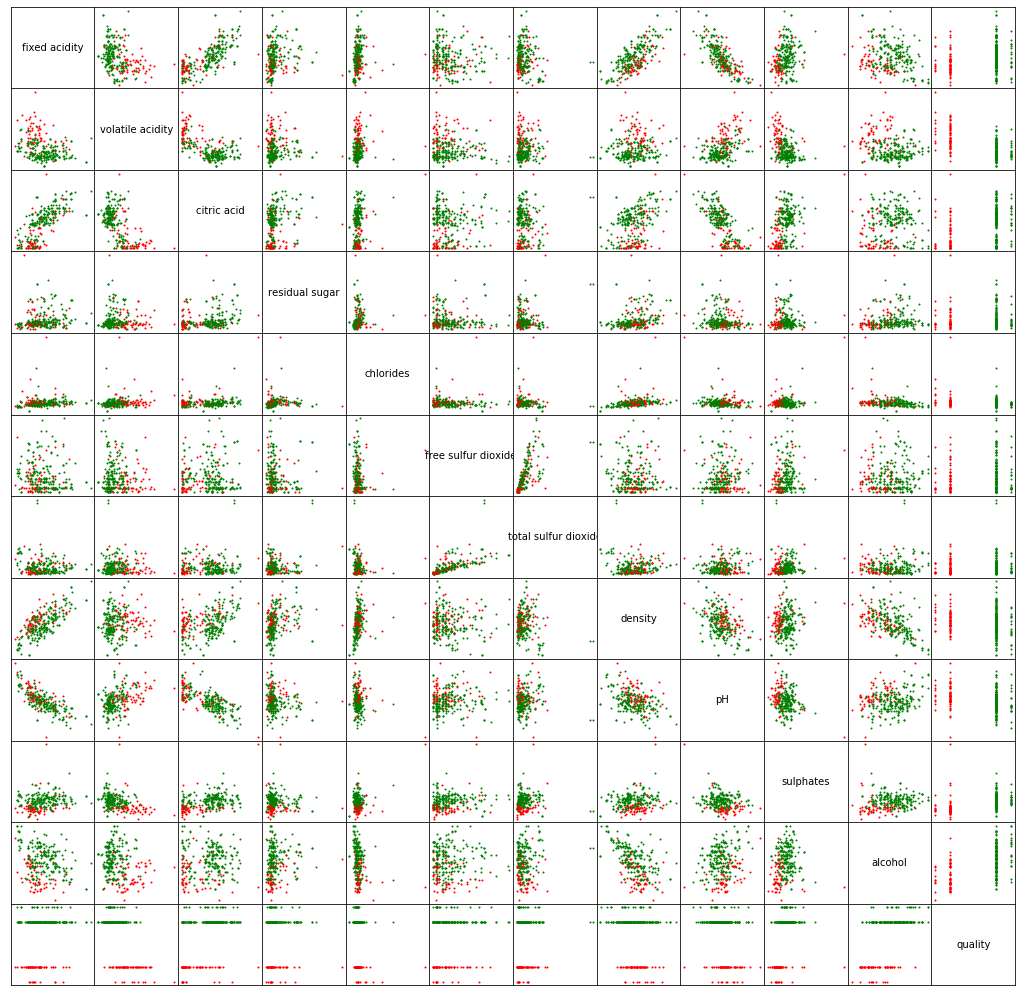

In [85]:
# for i, label in enumerate(df):
#     print(i)
#     print(label)
 scatterplot_matrix(df, 6, 5)